# Participation à SemEval 2022

In [23]:
import json
with open("./data/train-data_all/fr.dev.json", "r") as file_handler:
    dataset = json.load(file_handler)

### Construction du vecteur numérique

In [24]:
import stanza
from tqdm import trange
nlp = stanza.Pipeline('fr')

idx = 0
lemm2Idx = dict()
idx2Lemm = dict()

lemmatized_glosses = []

for gloss in trange(len(dataset)):
    lemmatized_gloss = []

    doc = nlp(dataset[gloss]['gloss'])
    for sentence in doc.sentences:
        for word in sentence.words:
            if word.pos != 'PUNCT':

                if word.lemma not in lemm2Idx:
                    lemm2Idx[word.lemma] = idx
                    idx2Lemm[idx] = word.lemma
                    idx += 1

                lemmatized_gloss.append(lemm2Idx[word.lemma])
    lemmatized_glosses.append(lemmatized_gloss)

2021-11-29 15:25:16 INFO: Loading these models for language: fr (French):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |
| depparse  | gsd     |
| ner       | wikiner |

2021-11-29 15:25:16 INFO: Use device: cpu
2021-11-29 15:25:16 INFO: Loading: tokenize
2021-11-29 15:25:16 INFO: Loading: mwt
2021-11-29 15:25:16 INFO: Loading: pos
2021-11-29 15:25:16 INFO: Loading: lemma
2021-11-29 15:25:16 INFO: Loading: depparse
2021-11-29 15:25:17 INFO: Loading: ner
2021-11-29 15:25:18 INFO: Done loading processors!
100%|██████████| 6375/6375 [30:47<00:00,  3.45it/s]  


In [30]:
# Export DATA
with open("data/lemm2Idx.json", "w") as outfile:
    json.dump(lemm2Idx, outfile)

with open("data/idx2Lemm.json", "w") as outfile:
    json.dump(idx2Lemm, outfile)

with open("data/lemmatized_glosses.json", "w") as outfile:
    json.dump(lemmatized_glosses, outfile)

In [34]:
# Import DATA
with open("./data/lemm2Idx.json") as outfile:
    lemm2Idx = json.load(outfile)

with open("./data/idx2Lemm.json") as outfile:
    idx2Lemm = json.load(outfile)

with open("./data/lemmatized_glosses.json") as outfile:
    lemmatized_glosses = json.load(outfile)

In [36]:
from keras.preprocessing.sequence import pad_sequences
pad_tokens = pad_sequences(lemmatized_glosses, padding='post')

In [37]:
from numpy.random import seed
import tensorflow

seed(1)
tensorflow.random.set_seed(2)

input_dim = len(idx2Lemm) + 1
output_dim = 32
input_length = max([len(s) for s in pad_tokens.tolist()])
n_tags = 256
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  8659 
output_dim:  32 
input_length:  111 
n_tags:  256


In [51]:
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=128))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add Embedding layer
    model.add(Embedding(input_dim=32, output_dim=256))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 128)         1108352   
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 64)         41216     
 nal)                                                            
                                                                 
 lstm_7 (LSTM)               (None, None, 32)          12416     
                                                                 
 embedding_7 (Embedding)     (None, None, 32, 256)     8192      
                                                                 
Total params: 1,170,176
Trainable params: 1,170,176
Non-trainable params: 0
_________________________________________________________________


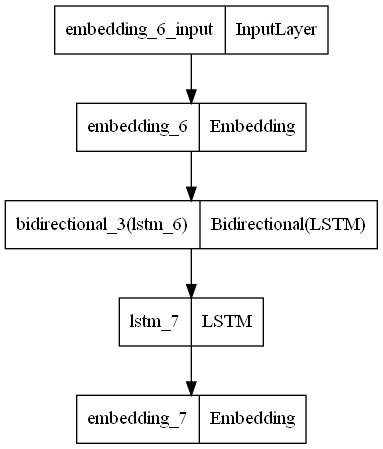

In [52]:
def train_model(X, y, model):
    loss = list()
    for _ in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)

In [53]:
import pandas as pd
import numpy as np
results = pd.DataFrame()
results['with_add_lstm'] = train_model(pad_tokens, np.array([i['sgns'] for i in dataset]), model_bilstm_lstm)

ValueError: in user code:

    File "C:\Users\julien.breton\Anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\julien.breton\Anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\julien.breton\Anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\julien.breton\Anaconda3\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "C:\Users\julien.breton\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\julien.breton\Anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\julien.breton\Anaconda3\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\julien.breton\Anaconda3\lib\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\julien.breton\Anaconda3\lib\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 256) and (None, 111, 32, 256) are incompatible
